# Statistics of Card Games

# 1. Deck Optimization

# 1.1 Binomial vs Hypergeometric Distribution

Consider a deck of $N$ cards, consisting of two types of cards $A$ and $B$, with quantities $N_A$ and $N_B$, such that $N = N_A + N_B$. For example, in MTG a deck could consist of lands and creatures. A player would start the game by drawing a hand of $n$ cards, consisting of $n=n_a+n_b$ cards of each subset. A standard problem is to determine the optimal ratio of $N_A$ and $N_B$, such that the ratio of $n_a$ and $n_b$ is most consistent. For example, we will always draw 10 cards, and we would like to maximize the probability of having 3 lands and 7 creatures.

If the deck is infinite, this probability follows the binomial probability distribution

\begin{equation}
P_B[n_a, n, p] = C^{n_a}_n p^{n_a} (1-p)^{n_b}
\end{equation}

where $p = N_a / N_b$. However, in reality, drawing cards from a deck decreases the number of cards in the deck, thus affecting the probabilities of drawing subsequent cards. The Hypergeometric distribution takes this into account

\begin{equation}
P_H[n_a, n, N, N_A] = \frac{C^{n_a}_{N_a} C^{n_b}_{N_b}}{C^n_N}
\end{equation}

As a first exercise, let us explore different sizes $N \in [40, 1000]$ of the decks, and see if it is feasible to approximate Hypergeometric distribution by Binomial

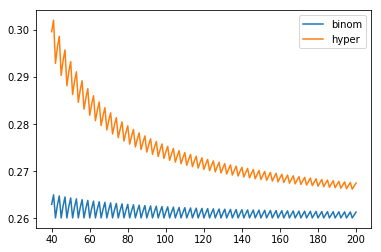

In [2]:
from scipy.stats import hypergeom, binom
import matplotlib.pyplot as plt
import numpy as np

Nmin = 40
Nmax = 200
p = 1.0/3.0
n = 10
na = 3

N = np.arange(Nmin, Nmax+1)
Na = (p * N).astype(int)

b_pmf = binom.pmf(na, n, Na/N)
h_pmf = hypergeom(N, Na, n).pmf(na)

plt.figure()
plt.plot(N, b_pmf, label="binom")
plt.plot(N, h_pmf, label="hyper")
plt.legend()
plt.show()

It is obvious, that even for the largest reasonable deck size of 200 cards, the error is at least 1%. To get a perspective of what 1% means, let us change one card from a land to a creature in a 100 card deck, and see the difference in probability of drawing 3 lands

In [3]:
P33 = hypergeom(100, 33, 10).pmf(3)
P34 = hypergeom(100, 34, 10).pmf(3)
print(P33, P34, P33-P34)

0.2741025881014971 0.2692196821025769 0.004882905998920217


The difference is 0.5%. Therefore, for the purposes of fine-tuning the deck land-creature ratio, one must always use the Hypergeometric distribution.

# MTG - distribution of opening hands

Calculating the probability of getting $N_{HAND}$ lands in your opening hand, given that there are $N_{DECK}$ lands in your deck

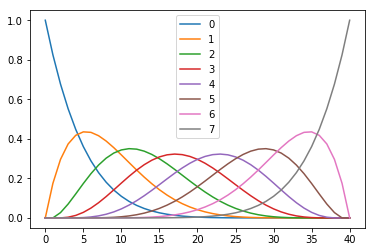

In [29]:
MTG_STARTING_HAND = 7

def startingHandDistr(nCardsDeck):
    nLandDeckLst = list(range(nCardsDeck+1))
    distr = np.zeros((nCardsDeck+1, MTG_STARTING_HAND+1), dtype=float)

    for nLandDeck in nLandDeckLst:
        distrDeck = hypergeom(nCardsDeck, nLandDeck, 7)
        for nLandHand in range(MTG_STARTING_HAND+1):
            distr[nLandDeck][nLandHand] = distrDeck.pmf(nLandHand)
            
    return nLandDeckLst, distr

nLandDeckLst, distrPaper = startingHandDistr(40)

plt.figure()
for nLandHand in range(MTG_STARTING_HAND+1):
    plt.plot(nLandDeckLst, distrPaper[:, nLandHand], label=str(nLandHand))
plt.legend()
plt.show()

# MTG Arena weird starting hand selection

MTG arena selects opening hand the following way

1. Calculate the ratio $R_{DECK} = \frac{NLAND_{DECK}}{N_{DECK}}$
2. Draw two random hands from the deck, for each hand calculate $R_{HAND} = \frac{NLAND_{HAND}}{N_{HAND}}$
3. Keep the hand for which $|R_{DECK} - R_{HAND}|$

Algorithm
1. Loop over number of lands in deck
2. Generate probability distribution of lands in hand. Generate CDF
3. Loop over 1000 trials
4. Generate two random hand land-to-total ratio's
5. Pick the one that is closer to original ratio, count

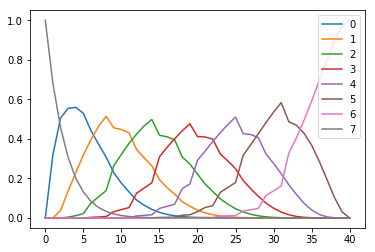

In [43]:
NCARD_DECK_THIS = 40
NCARD_HAND = 7
N_TRIAL = 500000

def CDF2IDX(CDF, p):
    for idx, val in enumerate(CDF):
        if val > p:
            return idx-1
    
    return idx
        
nLandDeckLst = list(range(NCARD_DECK_THIS+1))
distrArena = np.zeros((NCARD_DECK_THIS+1, NCARD_HAND+1), dtype=float)

for nLandDeck in nLandDeckLst:
    R_DECK = nLandDeck / NCARD_DECK_THIS
    
    distrPMF = hypergeom(NCARD_DECK_THIS, nLandDeck, NCARD_HAND).pmf
    distrSample = [distrPMF(nLandHand) for nLandHand in range(NCARD_HAND + 1)]
    distrCDF = [np.sum(distrSample[:i]) for i in range(NCARD_HAND + 2)][1:]
    
    for iTrial in range(N_TRIAL):
        N_HAND_1 = CDF2IDX(distrCDF, np.random.uniform(0, 1))
        N_HAND_2 = CDF2IDX(distrCDF, np.random.uniform(0, 1))
        
        DIST_HAND_1 = np.abs(N_HAND_1 / NCARD_HAND - R_DECK)
        DIST_HAND_2 = np.abs(N_HAND_2 / NCARD_HAND - R_DECK)
        
        if DIST_HAND_1 < DIST_HAND_2:
            distrArena[nLandDeck][N_HAND_1] += 1 / N_TRIAL
        else:
            distrArena[nLandDeck][N_HAND_2] += 1 / N_TRIAL
            
plt.figure()
for nLandHand in range(MTG_STARTING_HAND+1):
    plt.plot(nLandDeckLst, distrArena[:, nLandHand], label=str(nLandHand))
plt.legend()
plt.show()

In [44]:
import pandas as pd
from IPython.display import display, HTML

display(pd.DataFrame(distrPaper[15:22], index = list(range(15, 22))))
display(pd.DataFrame(distrArena[15:22], index = list(range(15, 22))))

,0,1,2,3,4,5,6,7
15,0.025784,0.142489,0.299227,0.308726,0.168396,0.048322,0.006711,0.000345
16,0.018564,0.115511,0.273579,0.319175,0.197585,0.064664,0.010309,0.000614
17,0.013150,0.092048,0.245461,0.322975,0.226082,0.083973,0.015268,0.001043
18,0.009148,0.072037,0.216112,0.320166,0.252763,0.106160,0.021906,0.001707
19,0.006237,0.055301,0.186642,0.311071,0.276507,0.130977,0.030561,0.002703
20,0.004158,0.041580,0.158004,0.296258,0.296258,0.158004,0.041580,0.004158
21,0.002703,0.030561,0.130977,0.276507,0.311071,0.186642,0.055301,0.006237


,0,1,2,3,4,5,6,7
15,0.028058,0.193754,0.418430,0.308756,0.048034,0.002250,0.000020,0.000698
16,0.017784,0.152988,0.410266,0.356838,0.058896,0.002854,0.000026,0.000348
17,0.010908,0.120360,0.395284,0.400522,0.069102,0.003624,0.000026,0.000174
18,0.006592,0.082096,0.307928,0.440932,0.148316,0.013828,0.000248,0.000060
19,0.003734,0.058936,0.272730,0.476192,0.171926,0.016118,0.000330,0.000034
20,0.002076,0.039882,0.222006,0.411406,0.291622,0.031352,0.001642,0.000014
21,0.001054,0.025532,0.171408,0.409588,0.337452,0.052912,0.002048,0.000006


# MTG - probability of manascrew and manaflood

To the 1st order approximation, MTG has 2 types of cards - lands and non-lands. The latter are used to actually play the game, while the former are used to pay for getting them into play. This design comes with an inherent problem - independent of the skill of the player, there always exists a possibility that too many or too few lands will be drawn at early stages of the game, resulting in a significant delay, and most likely a loss. We are interested in two questions

* How to optimize the land count in a deck, in order to minimize the effect
* What is the expected winrate ceiling due to this effect alone?

Let us consider a super-simplified midrange deck with two constraints
1. On turn 3, the deck wants to play a 3 cost card. That is, given a total of 10 cards drawn, 3 of them have to be lands. If there is less lands, you manascrew
2. On turn 3, the deck wants to have at least 5 playable cards. Thus, if there are more than 5 lands, the deck manafloods.

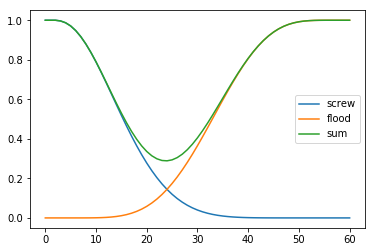

The optimal number of lands is 24 with total fail probability 0.28884804525048124


In [7]:
nlandLst = list(range(0, 61))
pscrewLst = []
pfloodLst = []
psumLst = []

for nland in nlandLst:
    pscrew = 0
    pflood = 0
    
    pscrew += hypergeom(60, nland, 10).pmf(0)
    pscrew += hypergeom(60, nland, 10).pmf(1)
    pscrew += hypergeom(60, nland, 10).pmf(2)
    
    pflood += hypergeom(60, nland, 10).pmf(6)
    pflood += hypergeom(60, nland, 10).pmf(7)
    pflood += hypergeom(60, nland, 10).pmf(8)
    pflood += hypergeom(60, nland, 10).pmf(9)
    pflood += hypergeom(60, nland, 10).pmf(10)
    
    pscrewLst.append(pscrew)
    pfloodLst.append(pflood)
    psumLst.append(pscrew + pflood)
    
plt.plot(nlandLst, pscrewLst, label="screw")
plt.plot(nlandLst, pfloodLst, label="flood")
plt.plot(nlandLst, psumLst, label="sum")
plt.legend()
plt.show()

minarg = np.argmin(psumLst)
minval = np.min(psumLst)

print("The optimal number of lands is", minarg,"with total fail probability", minval)

According to this, the highest possible winrate is roughly 75%, assuming opponent auto-concedes if you have a good hand. This number is an ok estimate I guess, but it does not consider several important facts:

1. Manascrewing and Manaflooding does not auto-lose the game, just progressively decreases the chances of winning.
2. Mulliganing is introduced to have a chance at exchanging horrible hands
3. There are actually more ways to screw up: color-screw, getting cards off curve (e.g. too expensive cards in the beginning), too little or too much card advantage vs creatures, only one part of a combo, etc.

# Hearthstone Arena

HS arena is a game mode where one assembles a deck by picking one of 3 random cards repeatedly, until a 30 card deck is assembled. One then proceeds to play games against other people. Any one game can be either a win or a loss. An arena run ends as soon as a person has accumulated 3 losses or 12 wins.

Firstly, let us have a look at the distribution of people of all possible win and loss combinations. Those are given by a binomial distribution, except that the very last result is fixed (i.e. one can only get to 3/3 from 3/2, but not from 2/3, because one is already out of the game at 2-3). Thus, before the person is out of the arena, the probability of achieving a certain result is

$P[n_w, n_l] = P_B[n_w, n_w+n_l, 0.5]$

If one has gotten 3 losses, it is

$P[n_w, 3] = 0.5 * P[n_w, 2]$

If one has gotten 12 wins, it is

$P[12,n_l] = 0.5 * P[11, n_l]$

In [16]:
for nw in range(0, 12+1):    
    for nl in range(0, 3+1):
        is_l = nl == 3
        is_w = nw == 12
        if is_w and is_l:
            continue
        elif is_w:
            rez = 0.5 * binom.pmf(nw-1, nw+nl-1, 0.5)
            print("%.4f" % rez, end=" ")
        elif is_l:
            rez = 0.5 * binom.pmf(nw, nw+nl-1, 0.5)
            print("%.4f" % rez, end=" ")
        else:
            rez = binom.pmf(nw, nw+nl, 0.5)
            print("%.4f" % rez, end=" ")
    print('\n')

1.0000 0.5000 0.2500 0.1250 

0.5000 0.5000 0.3750 0.1875 

0.2500 0.3750 0.3750 0.1875 

0.1250 0.2500 0.3125 0.1562 

0.0625 0.1562 0.2344 0.1172 

0.0312 0.0938 0.1641 0.0820 

0.0156 0.0547 0.1094 0.0547 

0.0078 0.0313 0.0703 0.0352 

0.0039 0.0176 0.0439 0.0220 

0.0020 0.0098 0.0269 0.0134 

0.0010 0.0054 0.0161 0.0081 

0.0005 0.0029 0.0095 0.0048 

0.0002 0.0015 0.0048 



Lets calculate the cumulative probability of each final result. That is, how many people will get at least a given result or better

12/0 0.00024
12/1 0.00171
12/2 0.00647
11/3 0.01123
10/3 0.01929
9/3 0.03271
8/3 0.05469
7/3 0.08984
6/3 0.14453
5/3 0.22656
4/3 0.34375
3/3 0.50000
2/3 0.68750
1/3 0.87500
0/3 1.00000
average number of wins is 2.99157714844


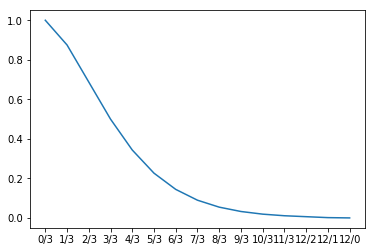

In [37]:
name = []
val = []

avg = 0
pcumul = 0
for nl in range(0, 3):
    pwin = 0.5 * binom.pmf(12-1, 12-1+nl, 0.5)
    avg += pwin * 12
    pcumul += pwin
    name.append("12/" + str(nl))
    val.append(pcumul)
    print(name[len(name)-1], "%.5f" % pcumul)

for nw in range(11, -1, -1):
    ploss = 0.5 * binom.pmf(nw, nw+3-1, 0.5)
    avg += ploss * nw
    pcumul += ploss
    name.append(str(nw) + "/3")
    val.append(pcumul)
    print(name[len(name)-1], "%.5f" % pcumul)

print("average number of wins is", avg)    

x = list(range(0, 15))
plt.xticks(x, list(reversed(name)))
plt.plot(x, list(reversed(val)))
plt.show()

The above distribution is also the distribution of results that a person with 50% winrate gets in Arena. As expected, getting at least 3 wins has 50%. A bit more subtle, but the average number of wins of a person with 50% winrate is slightly below 30%, because the possible number of wins is truncated at 12.

The next interesting question is: how does average number of wins depend on the winrate. In particular, in HS arena, it is useful to be able to get at least 7 wins on average, in order to have sufficient rewards to start another arena by paying with those.

average number of wins for winrate=50.0% is 2.99157714844
average number of wins for winrate=58.0% is 4.08914355129
average number of wins for winrate=63.5% is 5.05353638006
average number of wins for winrate=68.5% is 6.09908505111
average number of wins for winrate=72.5% is 7.04738699704


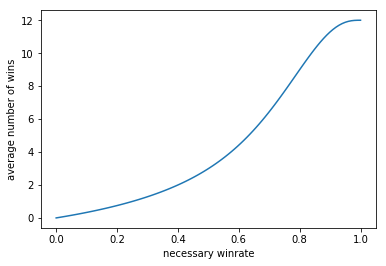

In [72]:
def avgArena(winrate):
    lossrate = 1 - winrate
    avg = 0
    for nl in range(0, 3):
        pwin = winrate * binom.pmf(12-1, 12-1+nl, winrate)
        avg += pwin * 12

    for nw in range(11, -1, -1):
        ploss = lossrate * binom.pmf(nw, nw+3-1, winrate)
        avg += ploss * nw

    return avg


print("average number of wins for winrate=50.0% is", avgArena(0.5))
print("average number of wins for winrate=58.0% is", avgArena(0.58))
print("average number of wins for winrate=63.5% is", avgArena(0.635))
print("average number of wins for winrate=68.5% is", avgArena(0.685))
print("average number of wins for winrate=72.5% is", avgArena(0.725))


x = np.linspace(0, 1, 100)
y = [avgArena(pw) for pw in x]
plt.xlabel("necessary winrate")
plt.ylabel("average number of wins")
plt.plot(x, y)
plt.show()

Thus, to get an average of 7 wins, one needs to win a bit less than 3/4 of games on average. Is it actually possible? There are two components to this answer:

1) Skill factor: is there enough people playing who have strictly less skill than you

2) Randomness factor: how many games does one auto-lose because of bad cards for deck building or bad draw? They will define the absolute ceiling